# Deep Learning groep 3

Team Diep Leren en Opereren
Groepsleden:
- Casper Priem - casperpriem
- Lars Timmer - laltir
- Matthias de Vreede - matthiasdevreede
- Willem van Dijk - willemvandijk

## Pre-requisites

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.model_selection import train_test_split
import geopandas as gpd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU, ELU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.utils import plot_model
import contextily as ctx
from sklearn.cluster import KMeans
import datetime as dt
import pathlib
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from functions import *

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

2025-03-30 12:15:30.369672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743329730.446820  213025 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743329730.471122  213025 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743329730.656313  213025 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743329730.656363  213025 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743329730.656365  213025 computation_placer.cc:177] computation placer alr

## Exploratory Data Analysis 

### First Look

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,250.500000,3.350000,2.669500,2369.64600,35.128844,-116.469049,5.980218e+05
std,144.481833,1.172283,1.017578,1208.18261,2.386173,6.554434,5.240649e+05
min,1.000000,1.000000,1.000000,701.00000,32.631500,-122.368300,2.200000e+04
25%,125.750000,2.000000,2.000000,1440.00000,33.808200,-119.802500,2.350000e+05
50%,250.500000,3.000000,2.500000,2097.50000,33.920800,-117.609600,5.300000e+05
75%,375.250000,4.000000,3.000000,3104.50000,35.640600,-116.371300,7.490000e+05
max,500.000000,10.000000,7.000000,9583.00000,47.791800,-87.885900,5.858000e+06


### Plot graphs

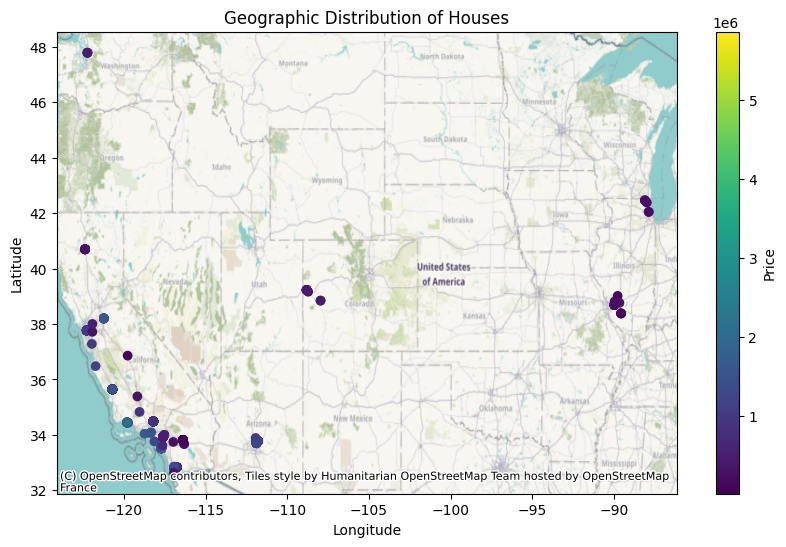

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(df['Longitude'], df['Latitude'], 
            c=df['Price'], cmap='viridis')
plt.colorbar(label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Geographic Distribution of Houses")
ctx.add_basemap(ax, crs="EPSG:4326")
plt.show()



**Analyse van de Geografische Spreiding en Prijsdistributie:**

1.  **Visualisatie:** De scatterplot visualiseert de geografische locaties van de huizen in de dataset aan de hand van hun latitude (Y-as) en longitude (X-as). De kleur van elk punt representeert de verkoopprijs ('Price'), waarbij paarstinten lagere prijzen en geeltinten hogere prijzen aangeven, zoals af te lezen is uit de color bar (variërend van circa 0 tot boven 5.5 miljoen dollar).

2.  **Ruimtelijke Clustering en Locaties:** De scatterplot visualiseert de locaties via latitude en longitude. De data vertoont duidelijke ruimtelijke clustering.
    * **Hoofdcluster (Westkust):** Een grote concentratie punten ligt tussen circa -123° en -115° longitude. Hoewel dit grotendeels overeenkomt met Californië, bevestigt de aanwezigheid van punten op hogere latitudes (tot ~48°N) dat niet alle data uit Californië komt. Een voorbeeld hiervan is een locatie zoals **48°24'12.2"N 120°10'26.5"W, wat in Washington State ligt (Bron: Google Maps)** en overeenkomt met een van de noordelijke punten in de plot binnen dit longitude-bereik.
    * **Andere Clusters:** Er zijn duidelijk aparte, kleinere clusters zichtbaar rond -90° longitude (Midwest/Zuid VS) en -110° longitude (Intermountain West).
    * Dit bevestigt de uitspraak uit de opdrachtbeschrijving dat de data *meestal* uit Californië komt, maar ook *andere locaties* bevat.

3.  **Prijsvariatie en Geografische Correlatie:**
    * De **hoogste prijzen** (gele punten, > $4M) lijken geconcentreerd te zijn binnen het hoofdcluster aan de Westkust, met name in het zuidelijkere deel (rond 34°-38° latitude). Binnen dit cluster is er echter ook een grote spreiding in prijzen, met veel woningen in lagere (paars/blauw) en middelhoge (groen/cyaan) prijsklassen.
    * De huizen in de clusters rond -90° en -110° longitude lijken **systematisch lagere prijzen** te hebben. De meeste punten hier vallen in de paarse/donkerblauwe range (waarschijnlijk < $1.5M), met enkele uitschieters naar de blauw/cyaan range. Er zijn geen extreem dure (gele) huizen zichtbaar in deze clusters.
    * De **noordelijke outliers** binnen het Westkust longitude-bereik (bv. rond 47.5° latitude) lijken relatief duur te zijn (groen/geel).

4.  **Implicaties voor Modellering:**
    * De sterke geografische clustering en de duidelijke correlatie tussen locatie en prijs suggereren dat latitude en longitude **belangrijke predictoren** zullen zijn voor de verkoopprijs.
    * De ruimtelijke heterogeniteit (verschillen tussen regio's) is significant. Een model moet in staat zijn deze ruimtelijke patronen te leren. Dit kan betekenen dat de coördinaten direct als input features gebruikt worden, of dat er mogelijk feature engineering nodig is om regio's te identificeren.
    * De aanwezigheid van extreem hoge prijzen geconcentreerd in één regio (Californië) kan de prestaties van een model beïnvloeden en vereist mogelijk speciale aandacht (bv. robuuste scaling, transformatie van de targetvariabele, of het gebruik van modellen die goed omgaan met dergelijke distributies).

Samengevat toont de plot aan dat de dataset geografisch geconcentreerd is in specifieke regio's (voornamelijk Californië) en dat er een sterke relatie bestaat tussen de locatie en de huizenprijs, waarbij de duurste huizen zich in het Californische cluster bevinden.

**Bron**:
https://www.google.com/maps/place/48%C2%B024'12.2%22N+120%C2%B010'26.5%22W/@41.5697893,-118.2066457,2004214m/data=!3m1!1e3!4m4!3m3!8m2!3d48.40338!4d-120.17403?entry=ttu&g_ep=EgoyMDI1MDMyNS4xIKXMDSoJLDEwMjExNDU1SAFQAw%3D%3D

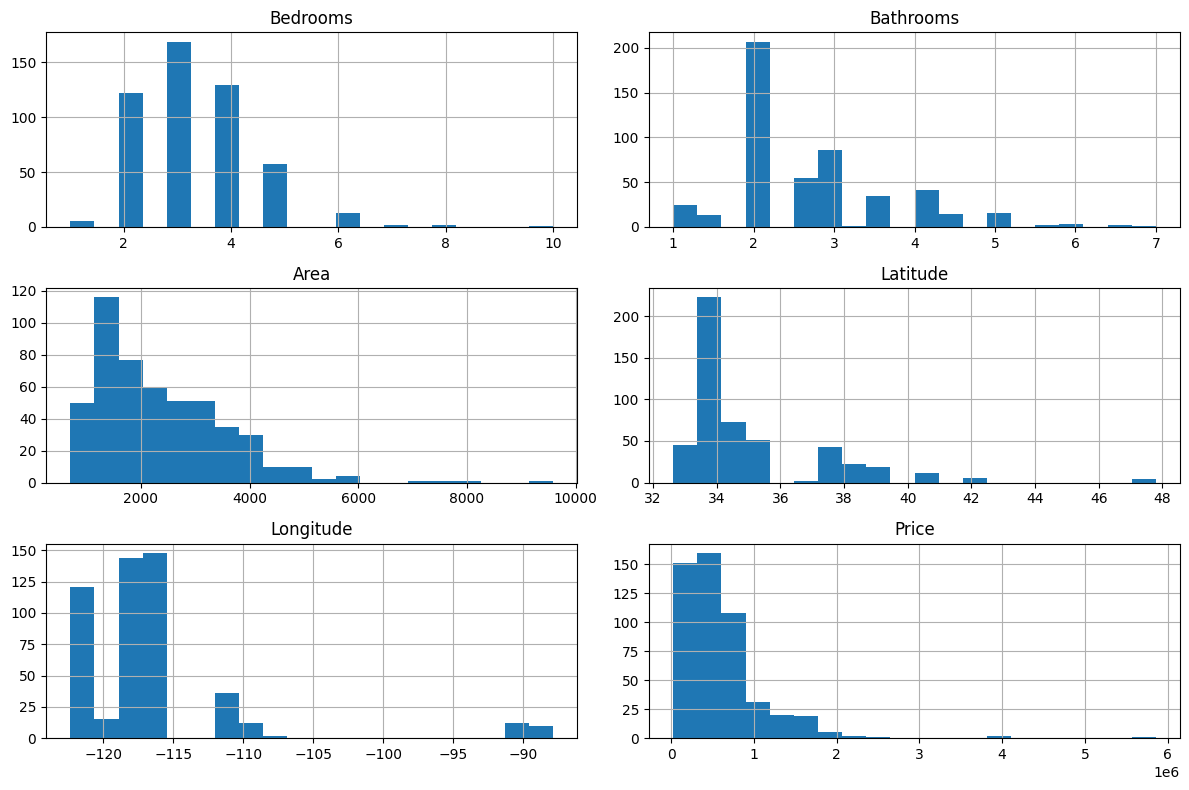

In [5]:
numeric_cols = ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude", "Price"]
df[numeric_cols].hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()


**Analyse van Variabelen Distributies:**

1.  **Bedrooms (Slaapkamers):**
    * **Type:** Discrete numerieke variabele.
    * **Verdeling:** De verdeling lijkt enigszins symmetrisch en unimodaal, gecentreerd rond 3-4 slaapkamers. De hoogste frequentie ligt bij 3 slaapkamers, dicht gevolgd door 4. Er is een snelle afname in frequentie voor huizen met meer dan 5 slaapkamers. Huizen met 2 slaapkamers komen ook relatief vaak voor.
    * **Range:** De meeste huizen hebben tussen de 2 en 5 slaapkamers. Waarden boven de 6 zijn zeldzaam.
    * **Implicaties:** Standaard numerieke behandeling lijkt mogelijk, al kan het vanwege het discrete karakter ook als ordinaal worden beschouwd.

2.  **Bathrooms (Badkamers):**
    * **Type:** Discrete numerieke variabele.
    * **Verdeling:** De verdeling is duidelijk **rechtsscheef (positively skewed)**. Er is een sterke piek bij 2 badkamers. De frequentie neemt sterk af naarmate het aantal badkamers toeneemt. 1 en 3 badkamers komen ook redelijk vaak voor.
    * **Range:** Meestal tussen 1 en 3 badkamers. Waarden boven de 4 zijn zeldzaam.
    * **Implicaties:** De scheefheid kan relevant zijn voor sommige modellen.

3.  **Area (Oppervlakte):**
    * **Type:** Continue numerieke variabele (waarschijnlijk in vierkante voet).
    * **Verdeling:** Sterk **rechtsscheef**. De overgrote meerderheid van de huizen heeft een relatief kleine oppervlakte (piek rond 1500-2000 sq ft). Er is een lange staart naar rechts, wat duidt op enkele huizen met een zeer grote oppervlakte (outliers > 6000 sq ft).
    * **Range:** De meeste huizen lijken een oppervlakte < 4000 sq ft te hebben, maar de range strekt zich uit tot bijna 10000 sq ft.
    * **Implicaties:** De sterke scheefheid suggereert dat een transformatie (bv. log-transformatie) van deze feature nuttig kan zijn voor modellen die gevoelig zijn voor de schaal of distributie van features.

4.  **Latitude (Breedtegraad):**
    * **Type:** Continue numerieke variabele.
    * **Verdeling:** **Multimodaal**. Er is een dominante piek rond 34 graden (Zuid-Californië?). Kleinere pieken zijn zichtbaar rond 38-39 graden, en mogelijk zwakkere pieken rond 41-42 graden en nabij 48 graden. Er zijn ook gebieden met lagere frequenties tussen deze pieken.
    * **Range:** Ligt tussen circa 32.5 en 48 graden.
    * **Implicaties:** Bevestigt de geografische clustering die in de scatterplot werd waargenomen. De pieken corresponderen met de dichtbevolkte dataregio's op de kaart. De multimodale aard benadrukt het belang van locatie.

5.  **Longitude (Lengtegraad):**
    * **Type:** Continue numerieke variabele.
    * **Verdeling:** **Multimodaal**. Er zijn duidelijke pieken die de geografische clusters bevestigen: de hoogste piek ligt rond -118 graden, een andere grote piek rond -122 graden. Kleinere, maar onderscheidende pieken liggen rond -110 graden en -90 graden.
    * **Range:** Ligt tussen circa -123 en -88 graden.
    * **Implicaties:** Bevestigt en kwantificeert de observaties uit de scatterplot over de locaties van de clusters. Longitude is, net als latitude, een belangrijke ruimtelijke feature.

6.  **Price (Prijs):**
    * **Type:** Continue numerieke variabele (target variabele).
    * **Verdeling:** Extreem **rechtsscheef**. De overgrote meerderheid van de huizenprijzen is geconcentreerd aan de lage kant (piek < $0.5M, meeste data < $1M-$1.5M). Er is een zeer lange staart naar rechts met enkele extreem dure huizen (outliers tot $6M).
    * **Range:** Strekt zich uit van nabij 0 tot ongeveer $6M.
    * **Implicaties:** Dit is een klassieke verdeling voor prijsdata. 

Samenvattend laten de histogrammen belangrijke kenmerken zien zoals scheefheid (Area, Price, Bathrooms) en multimodaliteit (Latitude, Longitude), wat directe input geeft voor feature engineering (bv. transformaties) en bevestigt dat locatie een cruciale rol speelt. \

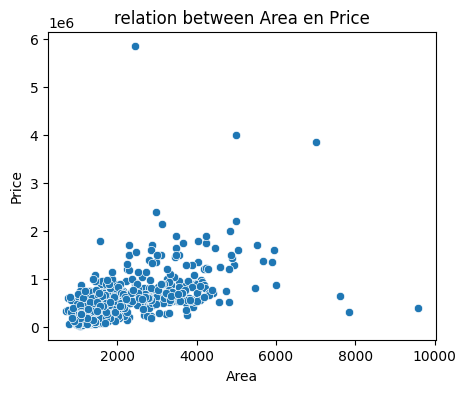

In [6]:
plt.figure(figsize=(5, 4))
sns.scatterplot(x="Area", y="Price", data=df)
plt.title("relation between Area en Price")
plt.show()


**Analyse van de Relatie tussen Oppervlakte en Prijs:**

1.  **Algemene Trend:** De scatterplot toont een duidelijke **positieve correlatie** tussen 'Area' en 'Price'. Over het algemeen geldt: hoe groter de oppervlakte ('Area' op de X-as), hoe hoger de prijs ('Price' op de Y-as). Dit is intuïtief logisch en bevestigt dat 'Area' een relevante predictor is voor de target variabele 'Price'.

2.  **Heteroscedasticiteit:** De relatie is niet perfect lineair en vertoont duidelijke **heteroscedasticiteit**. Dit betekent dat de spreiding (variantie) van de 'Price' toeneemt naarmate de 'Area' groter wordt. Bij kleinere oppervlaktes (bv. < 2000 sq ft) liggen de prijzen relatief dicht bij elkaar (meestal onder $1M). Bij grotere oppervlaktes (> 4000 sq ft) is de spreiding in prijzen veel groter; er zijn zowel relatief betaalbare grote huizen als extreem dure grote huizen. De punten waaieren dus uit naar rechtsboven.

3.  **Data Concentratie:** De meeste datapunten zijn geconcentreerd in het onderste linkerdeel van de grafiek (kleine oppervlakte, lagere prijs). Dit komt overeen met de rechtsscheve verdelingen die we eerder zagen in de histogrammen voor zowel 'Area' als 'Price'.

4.  **Outliers:** Er zijn enkele opvallende punten:
    * Huizen met een zeer grote oppervlakte (> 7000 sq ft) maar relatief gematigde prijzen (bv. rond $0.5M - $1M).
    * Huizen met een gemiddelde tot grote oppervlakte (bv. 2500 - 6000 sq ft) die extreem duur zijn (prijzen > $3M, oplopend tot bijna $6M). Deze punten dragen significant bij aan de heteroscedasticiteit.

5.  **Implicaties voor Modellering:**
    * De positieve correlatie bevestigt de relevantie van 'Area' als input feature.
    * Het neurale netwerk zal de non-lineaire relatie en de toenemende variantie (heteroscedasticiteit) moeten leren modelleren. Neurale netwerken zijn hier in principe goed toe in staat.

Samengevat: 'Area' is een belangrijke predictor met een positieve, maar heteroscedastische relatie tot 'Price'. De meeste data bevindt zich bij lagere oppervlaktes en prijzen, maar de variantie neemt toe voor grotere huizen. Dit patroon is een belangrijk kenmerk waarmee het neurale netwerk moet omgaan.

### Correlations

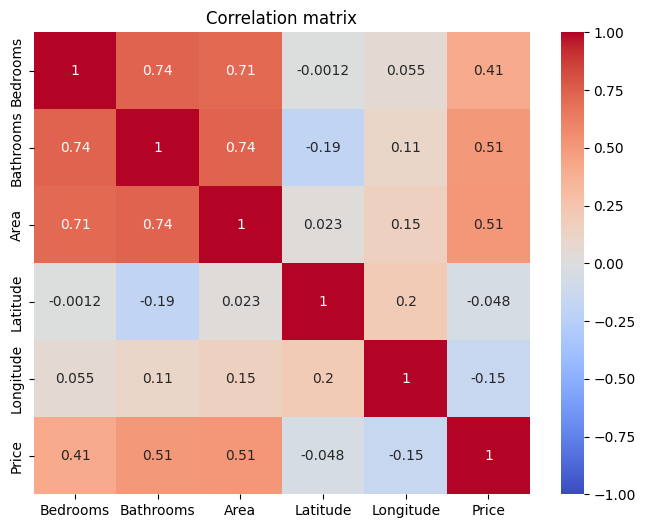

In [7]:
corr = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()


**Analyse van de Correlatiematrix:**

1.  **Visualisatie:** De heatmap toont de Pearson correlatiecoëfficiënten tussen alle numerieke variabelen in de dataset. Rode kleuren duiden op een positieve correlatie (dichter bij +1), blauwe kleuren op een negatieve correlatie (dichter bij -1), en kleuren rond wit/lichtgrijs duiden op een zwakke of geen lineaire correlatie (dicht bij 0).

2.  **Correlaties met de Target Variabele ('Price'):** We kijken naar de laatste rij (of kolom) om de lineaire relatie van elke feature met de verkoopprijs te zien:
    * **Area (Oppervlakte):** 0.51. Dit is een **matig sterke positieve correlatie**. Dit bevestigt de bevinding uit de scatterplot dat grotere huizen over het algemeen duurder zijn.
    * **Bathrooms (Badkamers):** 0.51. Eveneens een **matig sterke positieve correlatie**, vergelijkbaar met 'Area'. Meer badkamers hangt duidelijk samen met een hogere prijs.
    * **Bedrooms (Slaapkamers):** 0.41. Een **gematigde positieve correlatie**. Het aantal slaapkamers correleert ook positief met de prijs, maar iets minder sterk dan oppervlakte of aantal badkamers.
    * **Longitude (Lengtegraad):** -0.15. Een **zwakke negatieve correlatie**. Er is een lichte neiging dat huizen verder naar het westen (negatievere longitude) iets duurder zijn, maar de lineaire relatie is zwak.
    * **Latitude (Breedtegraad):** -0.048. Een **zeer zwakke negatieve correlatie**, praktisch dicht bij nul. Dit suggereert dat er over de gehele dataset geen significante *lineaire* trend is tussen latitude en prijs.

3.  **Correlaties Tussen Input Features (Multicollineariteit):** We kijken naar de correlaties tussen de input variabelen onderling:
    * **Area, Bathrooms, Bedrooms:** Er bestaan **sterke positieve correlaties** tussen deze drie variabelen:
        * `Area` vs `Bathrooms`: 0.74
        * `Area` vs `Bedrooms`: 0.71
        * `Bathrooms` vs `Bedrooms`: 0.74
        Dit geeft aan dat grotere huizen doorgaans zowel meer slaapkamers als meer badkamers hebben. Deze hoge onderlinge correlatie duidt op **multicollineariteit**.
    * **Latitude en Longitude:** Deze hebben een zwakke positieve correlatie (0.20).
    * **Locatie vs Grootte/Kamers:** De correlaties tussen locatie (Lat/Lon) en de grootte/kamer-features zijn over het algemeen zwak (meestal < |0.2|).

4.  **Implicaties voor Modellering:**
    * **Belangrijke Predictoren:** 'Area', 'Bathrooms' en 'Bedrooms' lijken de sterkste lineaire verbanden te hebben met 'Price' en zijn waarschijnlijk belangrijke predictoren.
    * **Locatie Features:** De zwakke *lineaire* correlaties van 'Latitude' en 'Longitude' met 'Price' betekenen **niet** dat locatie onbelangrijk is. De eerdere geografische plots toonden duidelijke, maar niet-lineaire, regionale prijsverschillen. Een neuraal netwerk is juist goed in het oppikken van zulke complexe, niet-lineaire verbanden die een simpele correlatiecoëfficiënt mist. Het is dus nog steeds cruciaal om Lat/Lon mee te nemen.
    * **Multicollineariteit:** De hoge correlatie tussen 'Area', 'Bathrooms' en 'Bedrooms' is een teken van multicollineariteit. Hoewel neurale netwerken hier over het algemeen robuuster tegen zijn dan bijvoorbeeld lineaire regressie (het beïnvloedt de interpreteerbaarheid van gewichten meer dan de voorspellende kracht), betekent het wel dat deze features deels overlappende informatie bevatten. Het is meestal geen reden om features te verwijderen voor een neuraal netwerk, maar het is goed om te weten.

Samenvattend bevestigt de correlatiematrix dat grootte-gerelateerde features (Area, Bathrooms, Bedrooms) lineair sterk samenhangen met de prijs en ook sterk met elkaar. Locatie (Latitude, Longitude) toont weinig lineaire correlatie met prijs op dataset-niveau, maar de eerdere EDA suggereert dat de ruimtelijke relatie complexer is en dus relevant blijft voor een non-lineair model zoals een neuraal netwerk.

### Outliers


In [8]:
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outliers = df[(df["Price"] < lower_bound) | (df["Price"] > upper_bound)]
print("Amount of outliers :", outliers.shape[0])


Amount of outliers : 23


In [9]:
display_house(1, df, folder='Train') # Display the house with ID 1, ID can be changed to any other ID

File not found: Train/1.jpg


**Analyse van de Voorbeeldafbeelding:**

1.  **Structuur en Bron:** De afbeelding is een compositie van vier individuele foto's, samengevoegd in een 2x2 grid. Elke sub-afbeelding representeert een specifiek deel van het huis: Badkamer (linksboven), Slaapkamer (rechtsboven), Keuken (linksonder), en Vooraanzicht (rechtsonder). Dit bevestigt de structuur van de beelddata zoals beschreven in de opdracht. Boven de afbeelding staat het ID (1) en de bijbehorende prijs ($869,500) vermeld.

2.  **Visuele Kenmerken (Huis ID 1):**
    * **Interieur:** De interieurfoto's (badkamer, slaapkamer, keuken) tonen ruimtes die redelijk modern en goed onderhouden lijken. De keuken heeft houten kasten en een eethoek, de slaapkamer is ruim met meubilair, en de badkamer heeft standaard voorzieningen.
    * **Exterieur:** Het vooraanzicht toont een huis (waarschijnlijk gelijkvloers) met een architectuurstijl die past bij een warm klimaat (stucwerk, mogelijk mediterraan of zuidwestelijk VS). De landscaping met grind en cactussen versterkt dit beeld.
    * **Algemene Indruk:** Het huis wekt de indruk van een redelijk luxe, goed onderhouden woning in een warme/droge regio. De prijs van $869,500 (in 2016 ) lijkt plausibel voor zo'n type huis in bepaalde Amerikaanse markten.

3.  **Informatiewaarde voor Modellen:** Deze afbeelding illustreert het type visuele informatie dat de Convolutional Neural Networks (CNNs) zullen ontvangen. Het doel is dat het model kenmerken uit deze beelden leert die correleren met de prijs, zoals:
    * **Grootte en Indeling:** Indirect af te leiden uit de ruimtelijkheid van de kamers en het vooraanzicht.
    * **Kwaliteit en Onderhoud:** Zichtbaar in de afwerking, staat van de keuken/badkamer, en het exterieur.
    * **Stijl en Moderniteit:** Kan indicatief zijn voor waarde.
    * **Locatiekenmerken:** Soms af te leiden uit de architectuur en landscaping (bv. stedelijk vs. landelijk, klimaatzone).

4.  **Overwegingen voor Beeldmodellering:**
    * **Variabiliteit:** Dit is slechts één voorbeeld. De kwaliteit, belichting, camerahoeken, en de staat/stijl van de huizen zullen aanzienlijk variëren over de gehele dataset. Het model moet robuust zijn voor deze variaties.
    * **Informatie per Quadrant:** Het model moet leren om relevante informatie uit alle vier de sub-afbeeldingen te halen en te integreren.
    * **Combinatie met Tabular Data:** Voor het multimodale model  is de uitdaging om de informatie uit deze samengestelde afbeelding effectief te combineren met de numerieke data (aantal kamers, oppervlakte, locatie ) voor hetzelfde huis om tot een nauwkeurigere prijsvoorspelling te komen dan met alleen beeld of alleen tabeldata mogelijk is.

Deze visualisatie is nuttig om een gevoel te krijgen bij de beelddata waarmee de neurale netwerken getraind zullen worden en onderstreept het multimodale karakter van de opdracht.

**Conclusie van de EDA**

De EDA is uitgevoerd op een dataset bestaande uit zowel **tabulaire data** (aantal slaapkamers, badkamers, oppervlakte, locatiecoördinaten) als **beelddata** (samengevoegde foto's van slaapkamer, badkamer, keuken, vooraanzicht) van huizen in de VS uit 2016. Het doel van de EDA was om inzicht te krijgen in de data ter voorbereiding op het ontwikkelen van deep learning modellen voor het voorspellen van de verkoopprijs ('Price').

**Belangrijkste Bevindingen:**

1.  **Data Kenmerken:**
    * De **tabulaire features** zoals `Area`, `Bathrooms`, en `Bedrooms` vertonen een (matig) sterke positieve lineaire correlatie met de target `Price`, wat intuïtief logisch is. Er bestaat echter ook aanzienlijke multicollineariteit tussen deze drie features.
    * De verdelingen van `Area` en vooral `Price` zijn **extreem rechtsscheef**. Dit wordt bevestigd door zowel de histogrammen als de scatterplot (`Area` vs `Price`), die ook duidelijke heteroscedasticiteit laat zien (toenemende prijsvariantie bij grotere oppervlakte).
    * De **locatiedata** (`Latitude`, `Longitude`) toont duidelijke **geografische clustering**, voornamelijk aan de Westkust maar ook in andere regio's. Hoewel de *lineaire* correlatie tussen coördinaten en prijs zwak is, suggereren de geografische plots sterke, niet-lineaire regionale prijsverschillen. Locatie is dus een cruciale factor.
    * Met de 1.5*IQR methode zijn **23 outliers** geïdentificeerd in de `Price` variabele, corresponderend met de extreem dure huizen in de staart van de verdeling.

2.  **Beelddata:**
    * De **beelddata** bestaat uit 4 afbeeldingen per huis. Een voorbeeld toont aan dat deze beelden informatie bevatten over de staat, stijl en locatiecontext van het huis. De kwaliteit en inhoud zullen naar verwachting variëren over de dataset.

**Implicaties voor Modellering:**

1.  **Feature Belang:** Alle onderzochte features (zowel tabulair als beeld) lijken potentieel relevant voor de prijsvoorspelling. De complexe, niet-lineaire relatie tussen locatie en prijs benadrukt de potentie van neurale netwerken om deze patronen te leren.
2.  **Preprocessing:**
    * **Schalen** van de numerieke input features (Area, Bedrooms, Bathrooms, Latitude, Longitude) is essentieel voor de training van neurale netwerken.
    * Er moet een **beslissing worden genomen over de 23 geïdentificeerde 'Price' outliers** (behouden of verwijderen), aangezien dit grote invloed kan hebben op het trainingsproces en de uiteindelijke prestaties.
3.  **Modellen:** De EDA onderstreept de relevantie van zowel tabel- als beelddata, wat de basis legt voor het ontwikkelen van de verschillende voorgeschreven modellen: een fully-connected netwerk voor tabeldata, een CNN voor beelddata, en een multimodaal model om beide te combineren. Het multimodale model heeft het potentieel om de synergie tussen de verschillende databronnen te benutten.

Deze EDA biedt een waardevol inzicht in de data en legt een basis voor de volgende stappen in het modelleringsproces, waarbij de gesignaleerde uitdagingen (met name de scheefheid van de target en de outliers) speciale aandacht vereisen.

### Data Preparation

In [10]:
house_ids = df["House ID"].values

In [11]:
images = []
for hid in house_ids:
    img_array = load_and_preprocess_image(hid, folder='Train/houses')
    images.append(img_array)

images = np.array(images)


Features for csv data

In [12]:
train = pd.read_csv('train.csv')

source  https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/

https://chatgpt.com/share/67dfde94-77f8-800b-93cc-ffa3c0778312


In [13]:
coastline = gpd.read_file("ne_10m_coastline.shp")
gdf_properties = gpd.GeoDataFrame(
    train,
    geometry=gpd.points_from_xy(train.Longitude, train.Latitude),
    crs="EPSG:4326"  # WGS84 Latitude/Longitude
)
gdf_properties = gdf_properties.to_crs(epsg=3857)
coastline = coastline.to_crs(epsg=3857)
train['distance_to_coast_m'] = gdf_properties.geometry.apply(
    lambda point: coastline.distance(point).min()
)

print(train.head())

/home/lars/anaconda3/envs/py310/lib/python3.10/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


   House ID  Bedrooms  Bathrooms  Area  Latitude  Longitude   Price  \
0         1         4        4.0  4053   33.6968  -111.8892  869500   
1         2         4        3.0  3343   34.8280  -119.0349  865200   
2         3         3        4.0  3923   33.7669  -111.9182  889000   
3         4         5        5.0  4022   33.7752  -111.7791  910000   
4         5         3        4.0  4116   33.7669  -111.9182  971226   

   distance_to_coast_m  
0        350887.562039  
1         77530.449791  
2        356761.999625  
3        366151.192977  
4        356761.999625  


In [14]:
#apply the same on test.csv
test = pd.read_csv('test.csv')
gdf_properties = gpd.GeoDataFrame(
    test,
    geometry=gpd.points_from_xy(test.Longitude, test.Latitude),
    crs="EPSG:4326"
)
gdf_properties = gdf_properties.to_crs(epsg=3857)
test['distance_to_coast_m'] = gdf_properties.geometry.apply(
    lambda point: coastline.distance(point).min()
)

/home/lars/anaconda3/envs/py310/lib/python3.10/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


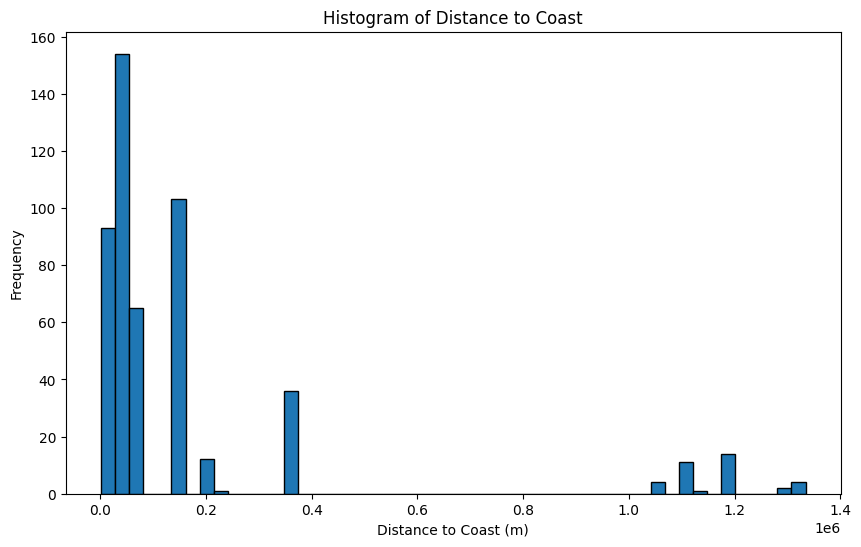

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(train['distance_to_coast_m'], bins=50, edgecolor='black')
plt.title('Histogram of Distance to Coast')
plt.xlabel('Distance to Coast (m)')
plt.ylabel('Frequency')
plt.show()

**Analyse van de Verdeling 'Distance to Coast':**

1.  **Feature Type:** Dit is een continue numerieke variabele, berekend op basis van de geografische coördinaten (Latitude, Longitude) van elk huis. Het kwantificeert de nabijheid van een huis tot de dichtstbijzijnde kustlijn.

2.  **Verdeling:** Het histogram toont een **multimodale verdeling** met verschillende duidelijke pieken en grote gaten ertussen:
    * **Piek nabij Nul:** Er is een zeer grote piek bij afstanden dicht bij nul meter. Dit geeft aan dat een significant deel van de huizen in de dataset zich **zeer dicht bij de kust** bevindt.
    * **Piek rond 150 km:** Een andere prominente piek ligt rond de 1.5e5 meter (150 km), wat duidt op een groep huizen die verder landinwaarts ligt, maar nog steeds relatief dichtbij een kust.
    * **Piek rond 400 km:** Een kleinere, maar duidelijke piek is zichtbaar rond 4e5 meter (400 km).
    * **Verre Afstanden:** Er zijn nog enkele kleinere clusters van huizen op veel grotere afstanden, met name rond 1.1e6 meter (1100 km) en 1.2e6 meter (1200 km). Er zijn grote intervallen waar vrijwel geen huizen voorkomen.

3.  **Interpretatie en Verband met Geografie:** Deze multimodale verdeling weerspiegelt de geografische spreiding die we eerder zagen:
    * De piek nabij nul komt waarschijnlijk overeen met de vele huizen in kustgebieden van Californië en mogelijk Washington/Oregon.
    * De pieken op 150 km en 400 km representeren huizen die verder landinwaarts liggen aan de Westkust.
    * De pieken op zeer grote afstanden (>1000 km) corresponderen hoogstwaarschijnlijk met de clusters die we identificeerden in het Midwesten/Zuiden (rond -90° longitude) en/of Intermountain West (rond -110° longitude), die inderdaad ver van de oceaan liggen.

4.  **Potentiële Predictieve Waarde:** Afstand tot de kust is vaak een belangrijke factor in huizenprijzen, vooral in kuststaten. Men verwacht vaak dat huizen dichter bij de kust duurder zijn (ceteris paribus). Deze engineered feature 'Distance to Coast' kan dus potentieel een **sterke predictor** zijn voor de 'Price', mogelijk zelfs informatiever dan Latitude/Longitude alleen, omdat het een specifieke, economisch relevante geografische eigenschap kwantificeert.

5.  **Implicaties voor Modellering:**
    * **Feature Selectie:** Deze afgeleide feature 'Distance to Coast' zou zeker moeten worden overwogen als input voor de modellen die tabular data gebruiken (het fully-connected netwerk en de tabel-tak van het multimodale model).
    * **Preprocessing:** Net als de andere numerieke features, moet ook 'Distance to Coast' **geschaald** worden (bv. met StandardScaler of MinMaxScaler) voordat het aan het neurale netwerk wordt gevoed.
    * **Relatie met Prijs:** Het zou interessant zijn om de correlatie tussen 'Distance to Coast' en 'Price' te berekenen en een scatterplot te maken om hun relatie nader te onderzoeken (hoewel niet hier getoond).

Samengevat, de verdeling van 'Distance to Coast' bevestigt de geografische spreiding van de dataset (kust vs. inland) en deze feature heeft een hoge potentie als waardevolle predictor voor de huizenprijs.

In [16]:
distances = np.array(train['distance_to_coast_m'])
distances_reshaped = distances.reshape(-1, 1)

# fit KMeans with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(distances_reshaped)
labels = kmeans.labels_

# Create a new column in 'train' to store cluster labels
train['cluster'] = labels

# Compute mean distance for each cluster
cluster_0 = train[train['cluster'] == 0]['distance_to_coast_m']
cluster_1 = train[train['cluster'] == 1]['distance_to_coast_m']

mean_0 = cluster_0.mean()
mean_1 = cluster_1.mean()

mean_prices = train.groupby('cluster')[['Price', 'distance_to_coast_m']].mean()
print(mean_prices)


                 Price  distance_to_coast_m
cluster                                    
0        619745.497845         8.929597e+04
1        318027.750000         1.165174e+06


**Analyse van de Clustering Resultaten:**

1.  **Cluster Definitie:** De clustering op basis van 'distance_to_coast_m' heeft de dataset succesvol opgedeeld in twee groepen:
    * **Cluster 0:** Huizen met een gemiddelde afstand tot de kust van circa **89,296 meter (ongeveer 89 km)**.
    * **Cluster 1:** Huizen met een gemiddelde afstand tot de kust van circa **1,165,174 meter (ongeveer 1165 km)**.
    Deze gemiddelde afstanden liggen ver uit elkaar en komen goed overeen met de pieken die we zagen in het histogram van 'Distance to Coast' (de pieken dichtbij 0-150km versus de pieken ver boven 1000km). Cluster 0 representeert dus de groep "dichtbij de kust", terwijl Cluster 1 de groep "ver landinwaarts" representeert.

2.  **Prijsverschillen tussen Clusters:** Het meest opvallende resultaat is het **grote verschil in gemiddelde prijs** tussen de clusters:
    * **Cluster 0 (dichtbij kust):** Gemiddelde prijs ≈ **$619,745**
    * **Cluster 1 (ver landinwaarts):** Gemiddelde prijs ≈ **$318,028**
    Huizen die dichter bij de kust liggen (Cluster 0) zijn in deze dataset gemiddeld **bijna twee keer zo duur** als huizen die ver landinwaarts liggen (Cluster 1).

3.  **Bevestiging van Relevantie:** Dit resultaat levert sterk kwantitatief bewijs voor de hypothese dat de **afstand tot de kust een significante factor is** in het bepalen van de huizenprijs binnen deze dataset. Het bevestigt de potentiële predictieve waarde van de eerder geanalyseerde 'distance_to_coast_m' feature.

4.  **Implicaties voor Modellering:**
    * De grote prijsverschillen tussen de clusters onderstrepen nogmaals het belang van locatie-gerelateerde features (`Latitude`, `Longitude`, en de afgeleide `distance_to_coast_m`) voor het nauwkeurig voorspellen van de 'Price'.
    * Het resultaat versterkt de aanbeveling om de feature `distance_to_coast_m` mee te nemen als input voor de neurale netwerken.
    * Hoewel de cluster-ID zelf als categorische feature gebruikt zou kunnen worden, bevat de continue 'distance_to_coast_m' variabele waarschijnlijk meer informatie voor een neuraal netwerk.

Deze clustering-analyse toont effectief aan dat er een sterke relatie bestaat tussen de nabijheid van de kust en de gemiddelde huizenprijs in deze dataset.

In [17]:
train.drop('cluster', axis=1, inplace=True)

In [18]:
#lower_bound = Q1 - 1.5*IQR
#upper_bound = Q3 + 1.5*IQR
#train = train[(train["Price"] >= lower_bound) & (train["Price"] <= upper_bound)]
#train.reset_index(drop=True, inplace=True)
#
#print(f"Shape after removing outliers: {train.shape}")

Als onderdeel van een iteratief proces hebben wij ook gemodelleerd nadat we de outliers hadden verwijderd, echter was het resultaat slechter en hebben we besloten om dit toch niet toe te passen.

## Modelling

### Fully-connected Neural Network

#### Model building

In [19]:
df = train

# Definieer features en target
feature_cols = ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude", "distance_to_coast_m"]
target_col = "Price"

X = df[feature_cols].values
y = np.log1p(df[target_col].values)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
initial_bias = np.log1p(df[target_col].mean())

In [22]:
def build_model(hp):
    # Kies tussen 'leaky' of 'elu' activation
    activation_choice = hp.Choice('activation', values=['leaky', 'elu'])
    if activation_choice == 'leaky':
        def activation_layer():
            return LeakyReLU(negative_slope=hp.Float('leaky_slope', 0.05, 0.2, step=0.05))
    else:
        def activation_layer():
            return ELU(alpha=hp.Float('elu_alpha', 0.8, 1.2, step=0.1))
    
    # Tune L2
    reg = l2(hp.Float('l2_reg', 1e-5, 1e-3, sampling='LOG'))
    
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(units=hp.Int('units1', min_value=64, max_value=256, step=32), kernel_regularizer=reg),
        BatchNormalization(),
        activation_layer(),
        Dropout(rate=hp.Float('dropout1', 0.0, 0.5, step=0.05)),
        
        Dense(units=hp.Int('units2', min_value=32, max_value=128, step=16), kernel_regularizer=reg),
        BatchNormalization(),
        activation_layer(),
        Dropout(rate=hp.Float('dropout2', 0.0, 0.5, step=0.05)),
        
        Dense(units=hp.Int('units3', min_value=16, max_value=64, step=16), kernel_regularizer=reg),
        BatchNormalization(),
        activation_layer(),
        Dropout(rate=hp.Float('dropout3', 0.0, 0.5, step=0.05)),
        
        # Outputlaag met een bias zodat de output begint dicht bij het gemiddelde van de log-transformatie
        Dense(1, activation='linear', bias_initializer=tf.keras.initializers.Constant(initial_bias))
    ])
    
    # Tune de learning rate
    lr = hp.Float('lr', 1e-4, 1e-2, sampling='LOG')
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_percentage_error',
        metrics=['mean_absolute_error', 'mean_squared_error']
    )
    return model

In [23]:
tuner = kt.RandomSearch(build_model, 
                        objective='val_loss', 
                        max_trials=100, 
                        executions_per_trial=5, 
                        directory='my_tuner_dir', 
                        project_name='house_price_tuning_extended_outliers_removed'
)

Reloading Tuner from my_tuner_dir/house_price_tuning_extended_outliers_removed/tuner0.json


In [ ]:
tuner.search(X_train, y_train, epochs=100, validation_split=0.2,
             callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
             verbose=1)

Trial 43 Complete [00h 01m 52s]
val_loss: 2.5253146171569822

Best val_loss So Far: 0.20602045953273773
Total elapsed time: 18h 29m 16s

Search: Running Trial #44

Value             |Best Value So Far |Hyperparameter
leaky             |elu               |activation
0.00011036        |2.6284e-05        |l2_reg
96                |64                |units1
0.15              |0.05              |leaky_slope
0.3               |0.2               |dropout1
64                |96                |units2
0.35              |0.45              |dropout2
32                |48                |units3
0.45              |0.15              |dropout3
0.00015084        |0.0082636         |lr
0.9               |1.1               |elu_alpha

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step - loss: 9.8898 - mean_absolute_error: 1.2670 - mean_squared_error: 2.7076 - val_loss: 19.5078 - val_mean_absolute_error: 2.4304 - val_mean_squared_error: 19.4506
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

In [ ]:
test_loss, test_mae, test_mape = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAPE (log-scale): {test_mape:.4f}")

In [ ]:
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mape_original = mean_absolute_percentage_error(y_true, y_pred)
print(f"Test MAPE (original scale): {mape_original*100:.2f}%")

In [ ]:
feature_cols = ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude", "distance_to_coast_m"]
X_test_new = test[feature_cols].values

# Predict using the best model (trained on log-transformed target values)
y_pred_log = best_model.predict(X_test_new)

# Invert the log transformation (np.expm1 is the inverse of np.log1p)
y_pred = np.expm1(y_pred_log)


submission = pd.DataFrame({
    'House ID': test['House ID'],
    'PredictedPrice': y_pred.flatten()
})

submission.to_csv(f'submission_nn_{dt.datetimne}.csv', index=False)
submission.head()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


,House ID,PredictedPrice
0,501,605600.37500
1,502,426474.53125
2,503,448319.93750
3,504,658434.06250
4,505,614218.06250


with outliers

Test MAPE (original scale): 37.64%

Kaggle score : Score: 0.59631

without outliers

Test MAPE (original scale): 28.74%

Kaggle score : Score:  0.64871


#### Model Visualisation

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8415 - mae: 0.6052 - mean_absolute_percentage_error: 4.7742 - val_loss: 0.2516 - val_mae: 0.3701 - val_mean_absolute_percentage_error: 2.9844
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7194 - mae: 0.6380 - mean_absolute_percentage_error: 4.9904 - val_loss: 0.2468 - val_mae: 0.3613 - val_mean_absolute_percentage_error: 2.9169
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6097 - mae: 0.5833 - mean_absolute_percentage_error: 4.5738 - val_loss: 0.2375 - val_mae: 0.3638 - val_mean_absolute_percentage_error: 2.9202
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5917 - mae: 0.5798 - mean_absolute_percentage_error: 4.5501 - val_loss: 0.2372 - val_mae: 0.3713 - val_mean_absolute_percentage_error: 2.9628
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5596 - mae: 0.5771 - mean_absolute_percentage_error: 4.5569 - val_loss: 0.2343 - val_mae: 0.3688 - val_mean_absolute_percentag

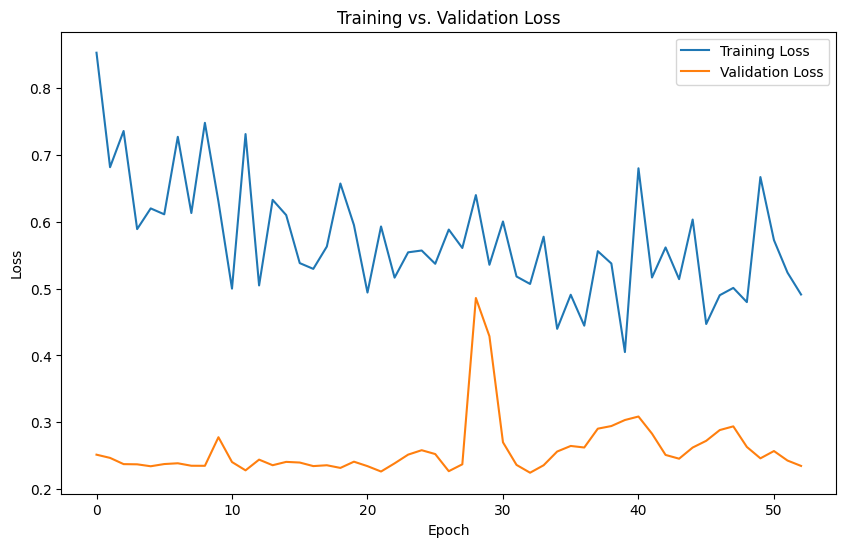

In [ ]:
history = best_model.fit(X_train, y_train, epochs=100, validation_split=0.2,
                         callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
                         verbose=1)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()


#### Model Explanation


##### Data Preparation 
- Features & Target:
The input features are numerical columns such as Bedrooms, Bathrooms, Area, Latitude, Longitude, and distance to coast. The target variable is the house price, but it’s transformed using a np.log1p to stabilize variance and help the model learn better.

- Initial Bias:
The model’s final layer is initialized with a bias equal to the average log-transformed price. This gives the network a good starting point so that its initial predictions are near the mean value. (also the reason I removed outliers so that the mean is more MEANingfull)

- Additional feature:
We have added distance_to_coast_m it spans from ~1.3 km to 1,334 km – a highly skewed distribution (most houses are tens of km from the coast, with a few extremely far inland). The data of the coastline is in the github as ne_10m_coastline.shp


##### Model 
- Dense Layers:
There are three fully-connected (Dense) hidden layers. The number of units in each Dense layer is tuned (for the first layer between 64 and 256 units, for the second between 32 and 128, and for the third between 16 and 64). Each Dense layer uses L2 regularization (with its strength also tuned), which helps prevent overfitting by penalizing large weight values.

- Batch Normalization:
After each Dense layer BatchNormalization is applied. This normalizes the output of the layer.

- Activation Layers:
The activation is chosen via hyperparameter tuning:
If ‘leaky’ is chosen, a LeakyReLU is used (with its negative slope tuned between 0.05 and 0.2).
Otherwise, an ELU is applied (with its alpha tuned between 0.8 and 1.2).
These activations add non-linearity to the model, allowing it to learn complex relationships.

- Dropout Layers:
After each activation, a Dropout layer is included. Dropout randomly “turns off” a fraction of neurons during training (with the dropout rate tuned between 0 and 0.5) to help prevent overfitting.

- Output Layer:
The final Dense layer has 1 neuron with a linear activation. The bias for this layer is set to the initial bias (average of the log target) so that it starts off with predictions near the mean value.


##### Training

- Optimizer & Learning Rate:
The model uses the Adam optimizer, which adapts the learning rate for each parameter. The learning rate itself is tuned (between 1e-4 and 1e-2).

- Loss Function & Metrics:
The loss function is Mean Squared Error (MSE), which is common for regression tasks and punishes big differences to reduce MAPE.

- Early Stopping:
The training uses an EarlyStopping callback with a patience of 20 epochs. This means if the validation loss doesn’t improve for 20 epochs, training stops and the best weights are restored.


- Hyperparameter Tuning:
The model is wrapped in a Keras Tuner RandomSearch, which explores different hyperparameter combinations (like the number of units, dropout rates, learning rate, activation type, etc.) to find the best settings based on validation loss.


##### Conclusion

Based on the training vs val loss graph you can see the loss fluctuating, this could be due to not enough data or noise. You can also tell that there is likely no overfitting since the VAL loss is lower or comparable to training loss most of the time.
After submitting the score on Kaggle you can see that the model is bad.

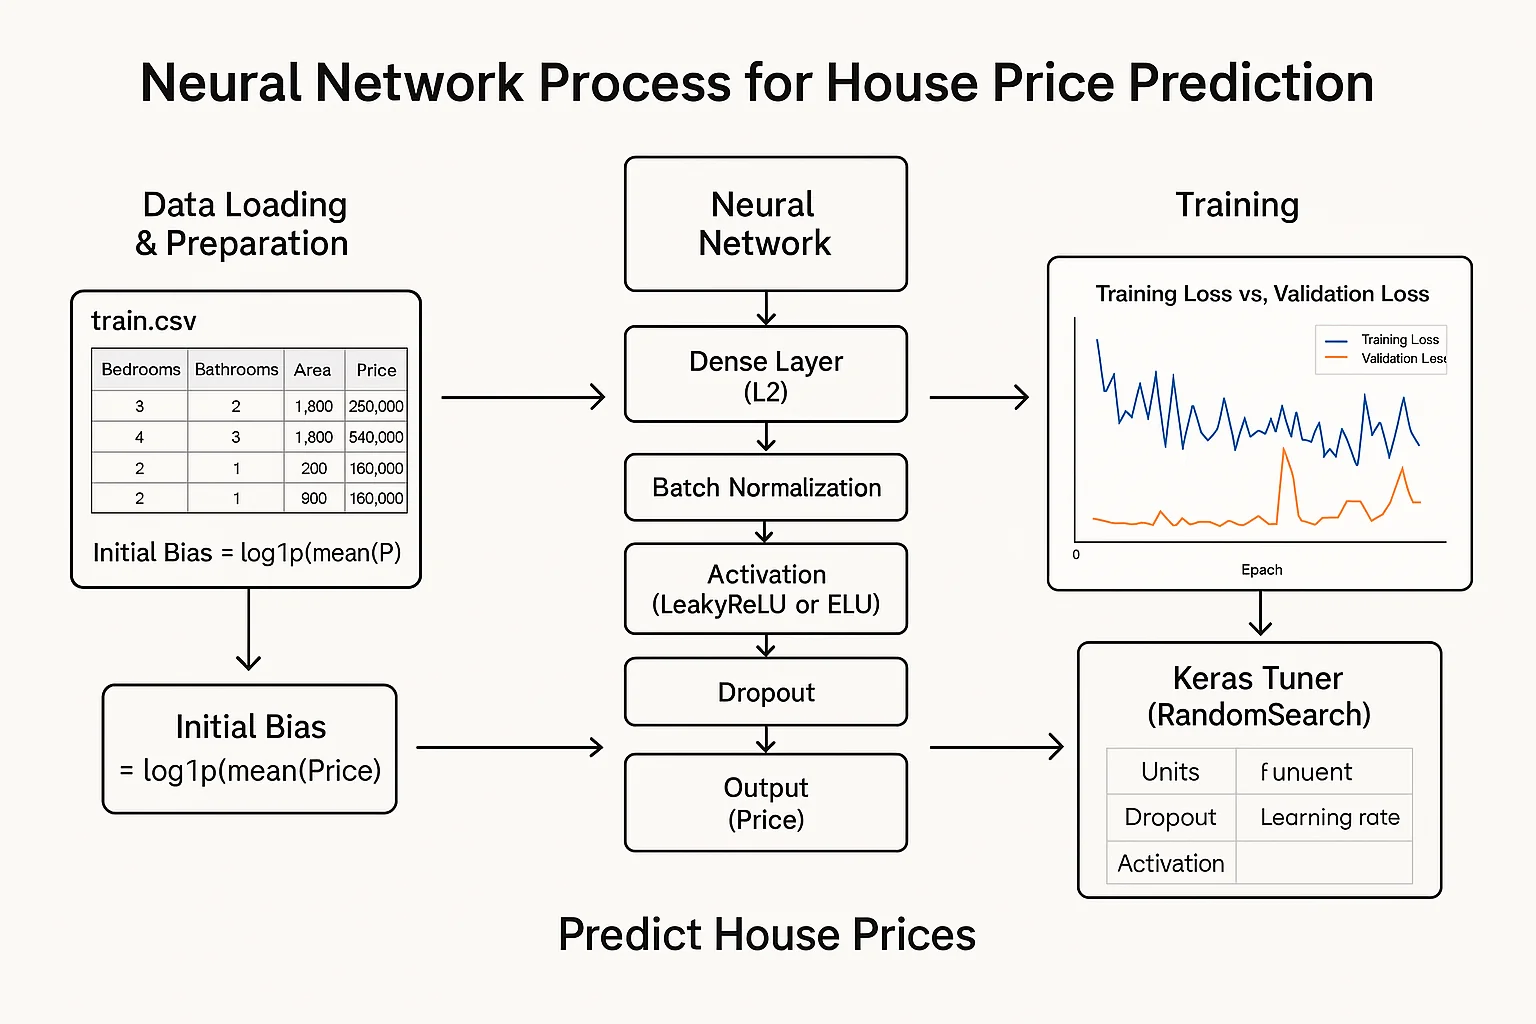

Generated with Sora AI from ChatGPT

Sources:

https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError

https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2

https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

https://keras.io/keras_tuner/


#### Model compilation

### Convolutional Neural Network

#### Model building

In [ ]:
# Define paths using pathlib
cnn__train_df = pathlib.Path("Train/") 
cnn_test_df = pathlib.Path("Test/")

# Hyperparameters
batch_size = 32
img_height = 180
img_width = 180

# Load Train dataset (split into training and validation)
train_ds = tf.keras.utils.image_dataset_from_directory(
    cnn__train_df,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    cnn__train_df,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load Test dataset (no validation split)
test_ds = tf.keras.utils.image_dataset_from_directory(
    cnn_test_df,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Print dataset details
print(f"Train batches: {len(train_ds)}, Validation batches: {len(val_ds)}, Test batches: {len(test_ds)}")

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.
Found 35 files belonging to 1 classes.
Train batches: 13, Validation batches: 4, Test batches: 2


In [ ]:
# Load CSV
df = pd.read_csv("train.csv")

# Define image size and directory
IMG_SIZE = (224, 224)
IMG_DIR = "train/house"

# Load images and labels
def load_image(filename):
    path = os.path.join(IMG_DIR, f"{str(filename)}.jpg")  # Ensure filename is a string
    img = load_img(path, target_size=IMG_SIZE)  # Resize image
    img = img_to_array(img) / 255.0  # Normalize
    return img

# Apply the function
X = np.array([load_image(f) for f in df["House ID"]])
y = np.array(df["Price"])  # Regression target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Reshape your target labels to 2D for scaling
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001EC19AED9E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step 


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 486ms/step - loss: 1.4870 - mean_absolute_error: 0.0901 - val_loss: 0.5238 - val_mean_absolute_error: 0.0539
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - loss: 0.4013 - mean_absolute_error: 0.0570 - val_loss: 0.2416 - val_mean_absolute_error: 0.0546
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - loss: 0.2061 - mean_absolute_error: 0.0616 - val_loss: 0.1233 - val_mean_absolute_error: 0.0547
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 472ms/step - loss: 0.1090 - mean_absolute_error: 0.0590 - val_loss: 0.0671 - val_mean_absolute_error: 0.0538
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 448ms/step - loss: 0.0601 - mean_absolute_error: 0.0535 - val_loss: 0.0394 - val_mean_absolute_error: 0.0663
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 453ms/step - loss: 0.0373 - mean_absolute_error: 0.0605 - val_loss: 0.0235 - val_mean_absolute_error: 0.0535
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 452ms/step - loss: 0.0265 - mean_absolute_error: 0.0

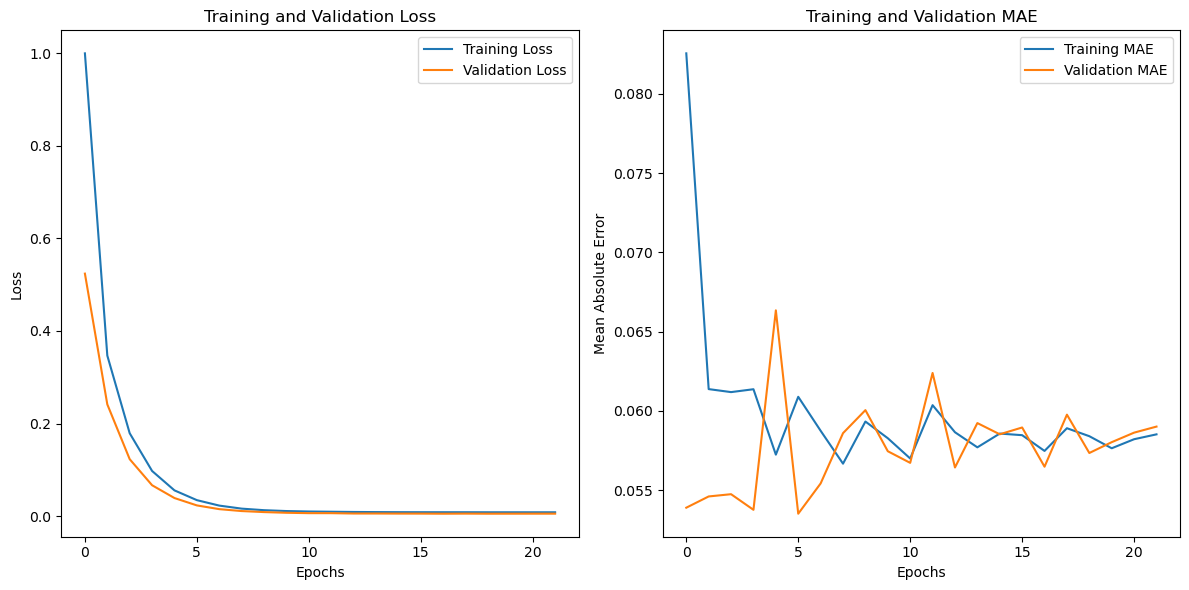

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
# Define Model

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),

    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1)
])
# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mean_absolute_error"])

# Define EarlyStopping Callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model and store the training history
history = model.fit(X_train, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_test, y_test_scaled), callbacks=[stop_early])

# Plotting training and validation loss and MAE
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation mean absolute error
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae}")

# Predict
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 174515519488.0000 - mae: 319344.3125
Test MAE: 331068.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [ ]:
# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

#### Model Visualisation

#### Model Explanation

#### Model compilation

### Transfer Learning

#### Model building

#### Model Visualisation

#### Model Explanation

#### Model compilation

### Multimodal model

In [ ]:
data = train.copy()
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['Price'] >= lower_bound) & (data['Price'] <= upper_bound)]

tabular_features = data[['Bedrooms', 'Bathrooms', 'Area', 'Latitude', 'Longitude', 'distance_to_coast_m']].values
prices = np.log1p(data['Price'].values)



image_paths = ["Train/house/{}.jpg".format(id) for id in data["House ID"]]
images = []
for path in image_paths:
    img = load_img(path, target_size=(224, 224))        # load image and resize to 224x224
    img_array = img_to_array(img)                       # convert to NumPy array
    images.append(img_array)
images = np.array(images, dtype="float32")
X_tab_train, X_tab_val, X_img_train, X_img_val, y_train, y_val = train_test_split(
    tabular_features, images, prices, test_size=0.2, random_state=42
)

mean = X_tab_train.mean(axis=0)
std = X_tab_train.std(axis=0)
X_tab_train = (X_tab_train - mean) / std
X_tab_val   = (X_tab_val   - mean) / std
X_img_train /= 255.0
X_img_val   /= 255.0



#### Model building

In [ ]:
def build_model(hp):
    # Image branch
    img_input = Input(shape=(224, 224, 3), name='image_input')
    x = tf.keras.layers.Rescaling(1.0/255)(img_input)


    kernel_size = hp.Choice('kernel_size', values=[3, 5])
    # Conv layer 1
    filters1 = hp.Int('filters1', min_value=16, max_value=64, step=16)
    x = layers.Conv2D(filters1, (kernel_size, kernel_size), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(hp.Float('dropout_conv1', 0.0, 0.5, step=0.1))(x)
    # Conv layer 2
    filters2 = hp.Int('filters2', min_value=32, max_value=128, step=32)
    x = layers.Conv2D(filters2, (kernel_size, kernel_size), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(hp.Float('dropout_conv2', 0.0, 0.5, step=0.1))(x)
    # Conv layer 3
    filters3 = hp.Int('filters3', min_value=32, max_value=128, step=32)
    x = layers.Conv2D(filters3, (kernel_size, kernel_size), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(hp.Float('dropout_conv3', 0.0, 0.5, step=0.1))(x)
    # Flatten and dense (image branch)
    x = layers.Flatten()(x)
    img_dense_units = hp.Int('dense_img_units', min_value=64, max_value=128, step=32)
    x = layers.Dense(img_dense_units, activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_img_dense', 0.0, 0.5, step=0.1))(x)
    img_features = x

    # Tabular branch
    tab_input = Input(shape=(6,), name='numeric_input')
    # First Dense layer for tabular data
    tab_dense1 = hp.Int('dense_tab1_units', min_value=32, max_value=128, step=32)
    y = layers.Dense(tab_dense1, activation='relu')(tab_input)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(hp.Float('dropout_tab1', 0.0, 0.5, step=0.1))(y)
    # Second Dense layer for tabular data
    tab_dense2 = hp.Int('dense_tab2_units', min_value=16, max_value=64, step=16)
    y = layers.Dense(tab_dense2, activation='relu')(y)
    y = layers.Dropout(hp.Float('dropout_tab2', 0.0, 0.5, step=0.1))(y)
    tab_features = y

    # Concatenate features from both branches
    combined = layers.Concatenate()([img_features, tab_features])
    # Dense layers after merging
    comb_dense1 = hp.Int('dense_comb1_units', min_value=32, max_value=128, step=32)
    z = layers.Dense(comb_dense1, activation='relu')(combined)
    z = layers.Dropout(hp.Float('dropout_comb1', 0.0, 0.5, step=0.1))(z)
    comb_dense2 = hp.Int('dense_comb2_units', min_value=16, max_value=64, step=16)
    z = layers.Dense(comb_dense2, activation='relu')(z)
    z = layers.Dropout(hp.Float('dropout_comb2', 0.0, 0.5, step=0.1))(z)

    # Output layer
    output = layers.Dense(1, activation='linear')(z)

    model = models.Model(inputs=[img_input, tab_input], outputs=output)

    # Compile model with a tunable learning rate
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mse',
                  metrics=['mae', 'mape'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='dir_no_outliers_try2',
    project_name='house_price_tuning'
)


tuner.search(
    x=[X_img_train, X_tab_train], y=y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=150,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)]
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hp.values)


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
test_df = pd.read_csv('test.csv')
gdf_properties = gpd.GeoDataFrame(
    test_df,
    geometry=gpd.points_from_xy(test_df.Longitude, test_df.Latitude),
    crs="EPSG:4326"
)
gdf_properties = gdf_properties.to_crs(epsg=3857)
coastline = coastline.to_crs(epsg=3857)
test_df['distance_to_coast_m'] = gdf_properties.geometry.apply(
    lambda point: coastline.distance(point).min()
)

print(train.head())



X_tab_test = test_df[['Bedrooms', 'Bathrooms', 'Area', 'Latitude', 'Longitude', 'distance_to_coast_m']].values
X_tab_test = (X_tab_test - mean) / std
image_paths_test = ["Test/{}.jpg".format(id) for id in test_df["House ID"]]
images_test = []
for path in image_paths_test:
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img)
    images_test.append(img_array)
images_test = np.array(images_test, dtype="float32")

images_test /= 255.0
y_pred_log_test = best_model.predict([images_test, X_tab_test])
y_pred_test = np.expm1(y_pred_log_test)

test_df['Predicted Price'] = y_pred_test.flatten()



c:\Users\caspe\OneDrive\Documents\GitHub\DeepLearning\.venv\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


   House ID  Bedrooms  Bathrooms  Area  Latitude  Longitude   Price  \
0         1         4        4.0  4053   33.6968  -111.8892  869500   
1         2         4        3.0  3343   34.8280  -119.0349  865200   
2         3         3        4.0  3923   33.7669  -111.9182  889000   
3         4         5        5.0  4022   33.7752  -111.7791  910000   
4         5         3        4.0  4116   33.7669  -111.9182  971226   

   distance_to_coast_m  
0        350887.562039  
1         77530.449791  
2        356761.999625  
3        366151.192977  
4        356761.999625  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


In [ ]:
submission = pd.DataFrame({
    'House ID': test_df['House ID'],
    'Price': test_df['Predicted Price']
})


In [ ]:
submission.to_csv('submission_collab_2.csv', index=False)

#### Model Visualisation

#### Model Explanation

This multimodal model predicts house prices by combining a 2D image CNN branch with a 1D tabular data branch in a network. Using the functional API, it accepts two inputs (an image and numerical features) and merges their learned representations before outputting a price prediction​

#### 
#### Model Explanation


##### Data Preparation 
- Features & Target:
The input features are numerical columns such as Bedrooms, Bathrooms, Area, Latitude, Longitude, and distance to coast. The target variable is the house price, but it’s transformed using a np.log1p to stabilize variance and help the model learn better. 

- Outlier Removal: 
Extreme outlier examples were removed using the IQR method. Any house price beyond 1.5 × IQR from the first or third quartile was dropped. Removing these outliers prevents them from skewing the model’s learning process and leads to a more robust model fit on the remaining data.

- Image Preprocessing: 
Each house image (e.g. a photo of the property) is loaded from disk and resized to 224×224 pixels. The images are converted into NumPy arrays of shape (224, 224, 3), and pixel values are normalized to the [0,1] range

- Additional feature:
We have added distance_to_coast_m it spans from ~1.3 km to 1,334 km – a highly skewed distribution (most houses are tens of km from the coast, with a few extremely far inland). The data of the coastline is in the github as ne_10m_coastline.shp


##### Model 
The model is built with two input branches that are later concatenated, enabling it to learn from both image and tabular data simultaneously​ [source](https://www.tensorflow.org/guide/keras/functional_api#:~:text=The%20Keras%20functional%20API%20is,even%20multiple%20inputs%20or%20outputs)


- Image Branch:
  The image input (224×224×3) is processed by three convolutional layers. Each conv layer (with tunable filters and kernel sizes) uses ReLU activation, followed by Batch Normalization, MaxPooling, and Dropout. The resulting feature maps are flattened and fed into a dense layer (with dropout) to extract visual features.  

- Tabular Branch:
  The six standardized features pass through two dense layers (with Batch Normalization and dropout) to learn a representation of the structured data.  


- Output: 
  Outputs from both branches are concatenated and processed through two additional dense layers with dropout before a final output layer. This output layer has a single neuron with linear activation that predicts the log-transformed house price.



##### Training

- Optimizer & Learning Rate:
The model uses the Adam optimizer, which adapts the learning rate for each parameter. The learning rate itself is tuned.

- Loss Function & Metrics:
The loss function is Mean Squared Error (MSE), which is common for regression tasks and punishes big differences to reduce MAPE.

- Early Stopping:
The training uses an EarlyStopping callback with a patience of 20 epochs. This means if the validation loss doesn’t improve for 20 epochs, training stops and the best weights are restored.


- Hyperparameter Tuning:
The model is wrapped in a Keras Tuner RandomSearch, which explores different hyperparameter combinations (like the number of units, dropout rates, learning rate, activation type, etc.) to find the best settings based on validation loss.





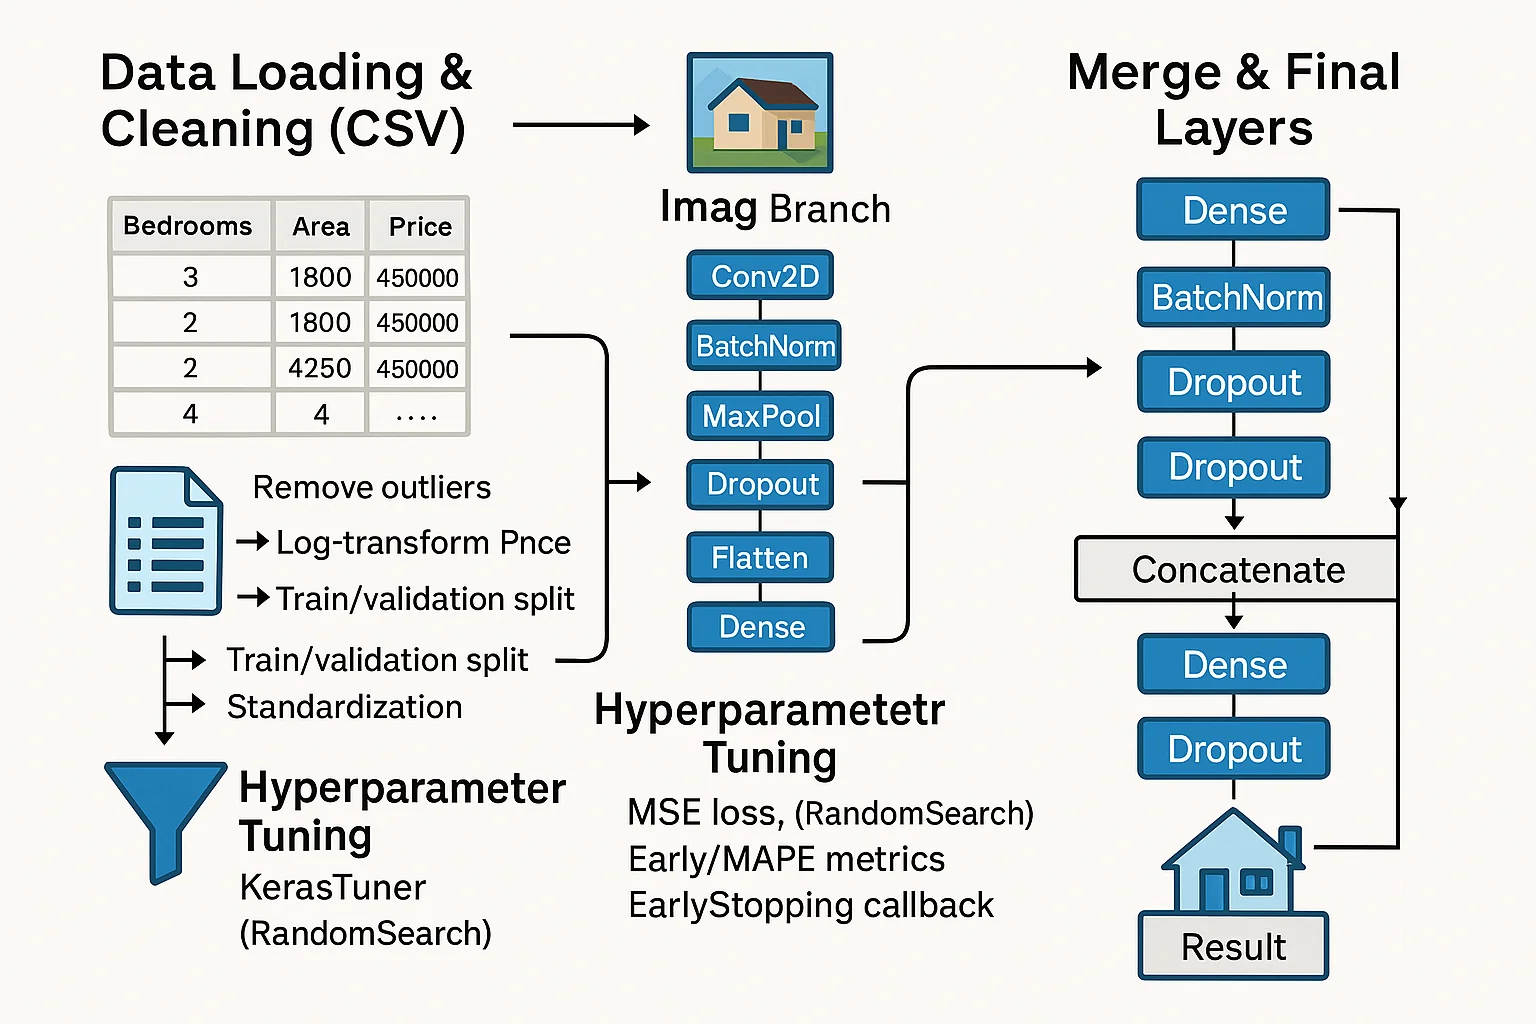


Generated with Sora AI from ChatGPT

#### Model compilation

## Bevindingen

- Geef een samenvatting van de uitkomsten van het modelleren.
- Geef een beknopt overzicht van de resultaten. 
- Welke model presteert het beste? Bij welke parameters?
- Toon je scores op Kaggle en laat zien wat de resultaten waren van je verbeteringen op je score op Kaggle.


## Conclusie

•	Beschrijf het modelleringsproces voor deze opdracht. Wat waren de uitdagingen daarmee?

•	In deze opdracht heb je verschillende modelarchitecturen uitgeprobeerd, en verschillende technieken om de prestaties te verbeteren. Welke van deze werkte het beste? Welke van deze werkte niet goed? Waarom denk je dat dat het geval was?

•	Welk advies kun je op basis hiervan geven aan een makelaar?

•	Welk advies kun je op basis hiervan geven aan potentiële huizenkopers of huizenverkopers?

